# Algoritmos de clasificación de imágenes con CIFAR-10

TODO: Descripción del notebook

## Importar librerías

In [ ]:
# Agregar librerías para análisis de datos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Importar sklearn
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Importar CIFAR-10 desde Keras
from keras.datasets import cifar10

## Preparación y exploración de los datos

### Cargar datos CIFAR-10

Cargamos el conjunto de imágenes obtenidos desde la librería Keras.

In [54]:
# Cargar el dataset CIFAR-10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print(f'Tamaño del conjunto de entrenamiento: {X_train.shape}, Etiquetas: {y_train.shape}')
print(f'Tamaño del conjunto de prueba: {X_test.shape}, Etiquetas: {y_test.shape}')

Tamaño del conjunto de entrenamiento: (50000, 32, 32, 3), Etiquetas: (50000, 1)
Tamaño del conjunto de prueba: (10000, 32, 32, 3), Etiquetas: (10000, 1)


### Analizar la distribución de las clases

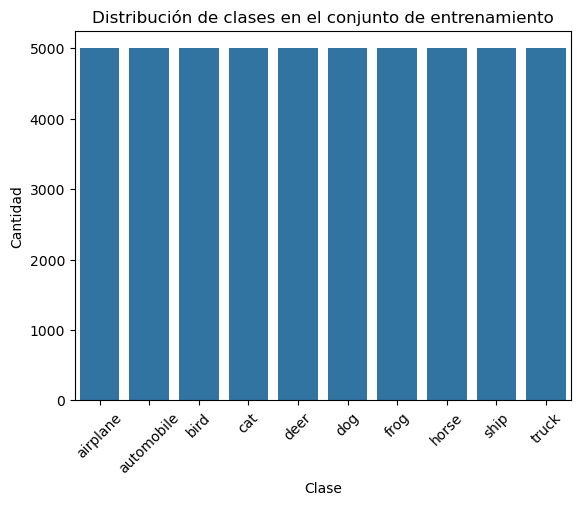

En total hay 10 clases:
Cada clase tiene 5000 imágenes en el conjunto de entrenamiento.


In [55]:
# Analizar la distribución de clases en el conjunto de entrenamiento
unique, counts = np.unique(y_train, return_counts=True)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

class_distribution = dict(zip(class_names, counts))

df_distribution = pd.DataFrame(list(class_distribution.items()), columns=['Clase', 'Cantidad'])

sns.barplot(x='Clase', y='Cantidad', data=df_distribution)
plt.title('Distribución de clases en el conjunto de entrenamiento')
plt.xticks(rotation=45)
plt.show()

print("En total hay {} clases:".format(len(class_names)))
print("Cada clase tiene {} imágenes en el conjunto de entrenamiento.".format(counts[0]))

### Visualizar algunas imágenes aleatorias junto con su etiqueta

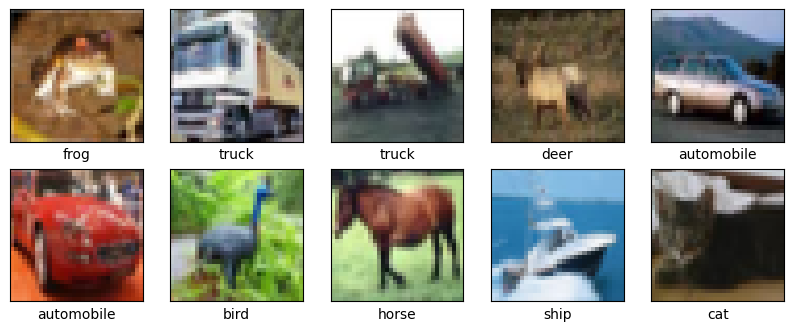

In [56]:
# Visualizar algunas imágenes del conjunto de entrenamiento


plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i])
    plt.xlabel(class_names[y_train[i][0]])
plt.show()

### Normalizar valores de píxeles

In [57]:
# Normalizar los datos
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0
y_train = y_train.flatten()
y_test = y_test.flatten()

# Comprobar la normalización
print(f'Valores mínimos y máximos en X_train: {X_train.min()}, {X_train.max()}')
print(f'Valores mínimos y máximos en X_test: {X_test.min()}, {X_test.max()}')

Valores mínimos y máximos en X_train: 0.0, 1.0
Valores mínimos y máximos en X_test: 0.0, 1.0


TODO: Analizar mejor.
---
En este caso, normalizamos los píxeles de las imágenes a valores entre 0 y 1, de forma que:

1. Los modelos se entrenan más rápido al usar valores entre 0 y 1 en lugar de 0 y 255.
2. Es más fácil para los modelos encontrar patrones y evitar sesos por difuminados, degradados, etc.

## Definición del problema de clasificación

- Un problema de clasificación binaria  (por ejemplo: ¿es un  perro o no es un perro?).
    - TODO:


- Un problema de con las 10 categorías.
    - TODO:

## Entrenamiento de modelos

### Clasificación binaria

In [58]:
# Definimos semilla para reproducibilidad
np.random.seed(42)

# Target a comparar: Ship (clase 8) vs No-Ship
y_train_binary = (y_train == 8).astype(int)
y_test_binary = (y_test == 8).astype(int)

#### DummyClassifier

In [59]:
# Clasificación binaria con DummyClassifier
dummy_clf_bin = DummyClassifier(strategy="stratified")
dummy_clf_bin.fit(X_train.reshape(X_train.shape[0], -1), y_train_binary)

DummyClassifier(strategy='stratified')

#### Matríz de confusión

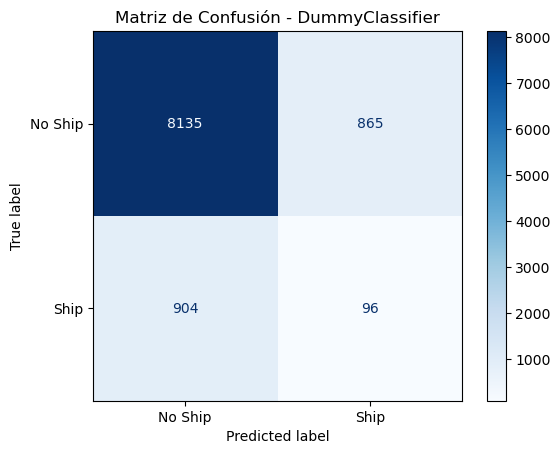

In [60]:
# Matriz de confusión para DummyClassifier (binario)
y_pred_dummy = dummy_clf_bin.predict(X_test.reshape(X_test.shape[0], -1))
cm_dummy = confusion_matrix(y_test_binary, y_pred_dummy)
disp_dummy = ConfusionMatrixDisplay(confusion_matrix=cm_dummy, display_labels=['No Ship', 'Ship'])
disp_dummy.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusión - DummyClassifier')
plt.show()

# print("Reporte de clasificación - DummyClassifier:")
# print(classification_report(y_test_binary, y_pred_dummy, target_names=['No Ship', 'Ship']))

# print("\nNo ships correctamente clasificados (Verdaderos Negativos): ", cm_dummy[0][0])
# print("No ships que fueron incorrectamente clasificados como ships (Falsos Positivos): ", cm_dummy[0][1])
# print("Ships que no fueron detectados (Falsos Negativos):  ", cm_dummy[1][0])
# print("Ships correctamente clasificados (Verdaderos Positivos): ", cm_dummy[1][1])

#### SGDClassifier

In [61]:
# Modelo SGDClassifier para clasificación binaria
sgd_clf_bin = SGDClassifier(max_iter=1000, tol=1e-3)
sgd_clf_bin.fit(X_train.reshape(X_train.shape[0], -1), y_train_binary)

SGDClassifier()

#### Matríz de confusión

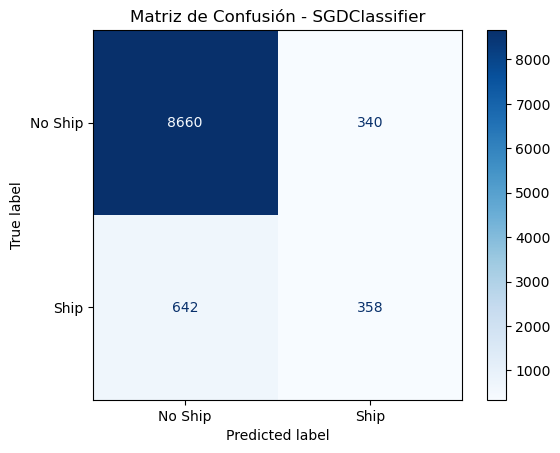

Reporte de clasificación - SGDClassifier:
              precision    recall  f1-score   support

     No Ship       0.93      0.96      0.95      9000
        Ship       0.51      0.36      0.42      1000

    accuracy                           0.90     10000
   macro avg       0.72      0.66      0.68     10000
weighted avg       0.89      0.90      0.89     10000



In [62]:
# Matriz de confusión para SGDClassifier (binario)
y_pred_sgd = sgd_clf_bin.predict(X_test.reshape(X_test.shape[0], -1))
cm_sgd = confusion_matrix(y_test_binary, y_pred_sgd)
disp_sgd = ConfusionMatrixDisplay(confusion_matrix=cm_sgd, display_labels=['No Ship', 'Ship'])
disp_sgd.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusión - SGDClassifier')
plt.show()

print("Reporte de clasificación - SGDClassifier:")
print(classification_report(y_test_binary, y_pred_sgd, target_names=['No Ship', 'Ship'], zero_division=0))

# print("\nNo ships correctamente clasificados (Verdaderos Negativos): ", cm_sgd[0][0])
# print("No ships que fueron incorrectamente clasificados como ships (Falsos Positivos): ", cm_sgd[0][1])
# print("Ships que no fueron detectados (Falsos Negativos):  ", cm_sgd[1][0])
# print("Ships correctamente clasificados (Verdaderos Positivos): ", cm_sgd[1][1])

### Clasificación Multiclase

#### DummyClassifier

In [63]:
dummy_clf_multi = DummyClassifier(strategy="stratified")
dummy_clf_multi.fit(X_train.reshape(X_train.shape[0], -1), y_train)

DummyClassifier(strategy='stratified')

#### Matriz de confusión

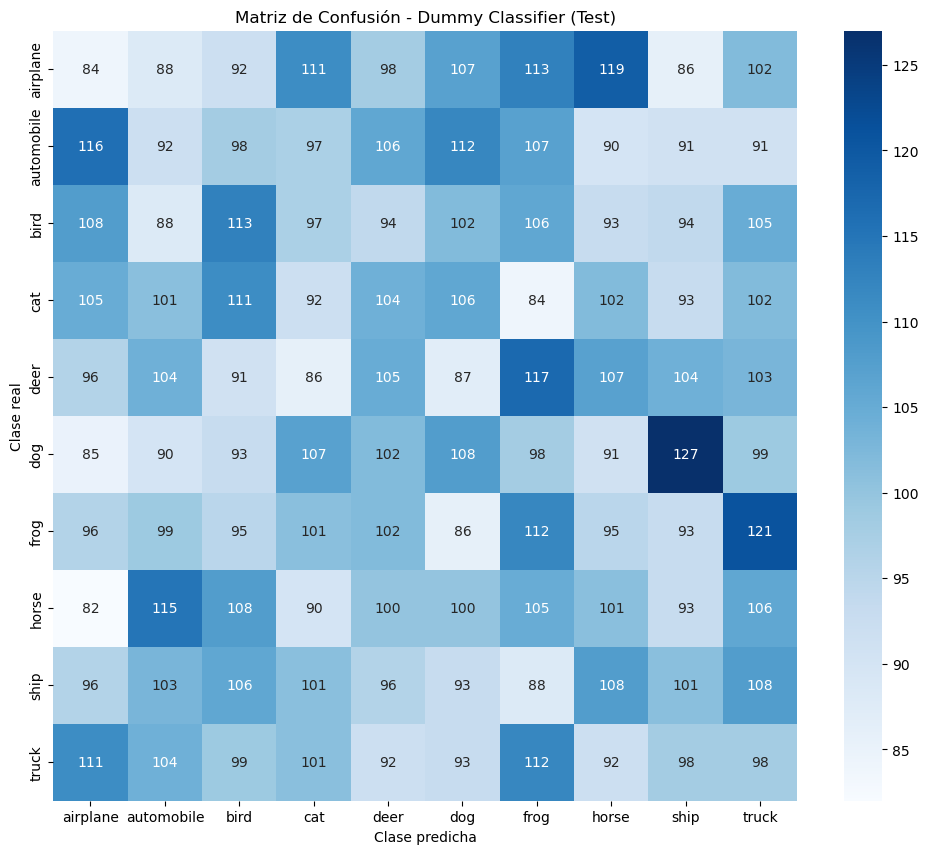

Reporte de clasificación para Dummy Classifier:

              precision    recall  f1-score   support

    airplane       0.09      0.08      0.08      1000
  automobile       0.09      0.09      0.09      1000
        bird       0.11      0.11      0.11      1000
         cat       0.09      0.09      0.09      1000
        deer       0.11      0.10      0.11      1000
         dog       0.11      0.11      0.11      1000
        frog       0.11      0.11      0.11      1000
       horse       0.10      0.10      0.10      1000
        ship       0.10      0.10      0.10      1000
       truck       0.09      0.10      0.10      1000

    accuracy                           0.10     10000
   macro avg       0.10      0.10      0.10     10000
weighted avg       0.10      0.10      0.10     10000



In [64]:
y_train_pred_dummy = dummy_clf_multi.predict(X_train.reshape(X_train.shape[0], -1))
y_test_pred_dummy = dummy_clf_multi.predict(X_test.reshape(X_test.shape[0], -1))

cm_train_dummy = confusion_matrix(y_train, y_train_pred_dummy)
cm_test_dummy = confusion_matrix(y_test, y_test_pred_dummy)

# Convertir a DataFrame para mejor legibilidad
cm_test_df = pd.DataFrame(cm_test_dummy, index=class_names, columns=class_names)

# Mostrar como heatmap
plt.figure(figsize=(12,10))
sns.heatmap(cm_test_df, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión - Dummy Classifier (Test)")
plt.ylabel("Clase real")
plt.xlabel("Clase predicha")
plt.show()

# Reporte de clasificación
print("Reporte de clasificación para Dummy Classifier:\n")
print(classification_report(y_test, y_test_pred_dummy, target_names=class_names, zero_division=0))

#### SGDClassifier

In [65]:
sgd_clf_multi = SGDClassifier(max_iter=1000, tol=1e-3)
sgd_clf_multi.fit(X_train.reshape(X_train.shape[0], -1), y_train)

SGDClassifier()

#### SGDClassifier - Matriz de confusión

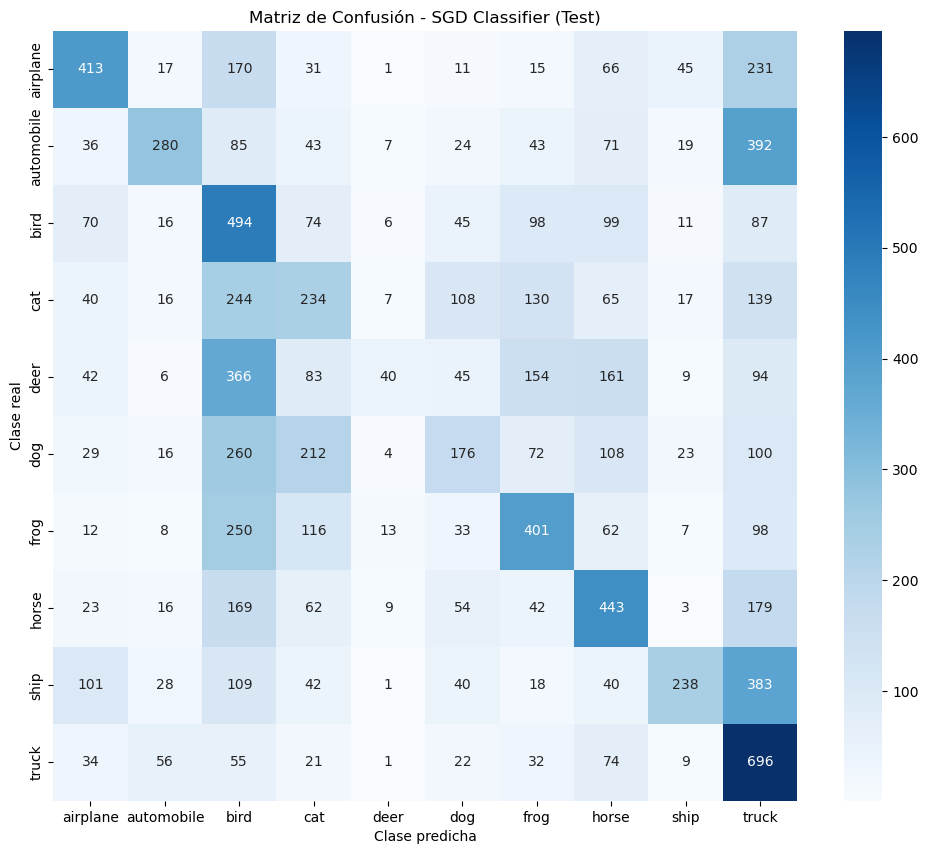

Reporte de clasificación para SGD Classifier en el conjunto de prueba:
              precision    recall  f1-score   support

    airplane       0.52      0.41      0.46      1000
  automobile       0.61      0.28      0.38      1000
        bird       0.22      0.49      0.31      1000
         cat       0.25      0.23      0.24      1000
        deer       0.45      0.04      0.07      1000
         dog       0.32      0.18      0.23      1000
        frog       0.40      0.40      0.40      1000
       horse       0.37      0.44      0.40      1000
        ship       0.62      0.24      0.34      1000
       truck       0.29      0.70      0.41      1000

    accuracy                           0.34     10000
   macro avg       0.41      0.34      0.33     10000
weighted avg       0.41      0.34      0.33     10000



In [66]:
y_train_pred_sgd = sgd_clf_multi.predict(X_train.reshape(X_train.shape[0], -1))
y_test_pred_sgd = sgd_clf_multi.predict(X_test.reshape(X_test.shape[0], -1))

cm_train_sgd = confusion_matrix(y_train, y_train_pred_sgd)
cm_test_sgd = confusion_matrix(y_test, y_test_pred_sgd)

cm_test_sgd_df = pd.DataFrame(cm_test_sgd, index=class_names, columns=class_names)

plt.figure(figsize=(12,10))
sns.heatmap(cm_test_sgd_df, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión - SGD Classifier (Test)")
plt.ylabel("Clase real")
plt.xlabel("Clase predicha")
plt.show()

print("Reporte de clasificación para SGD Classifier en el conjunto de prueba:")
print(classification_report(y_test, y_test_pred_sgd, target_names=class_names))

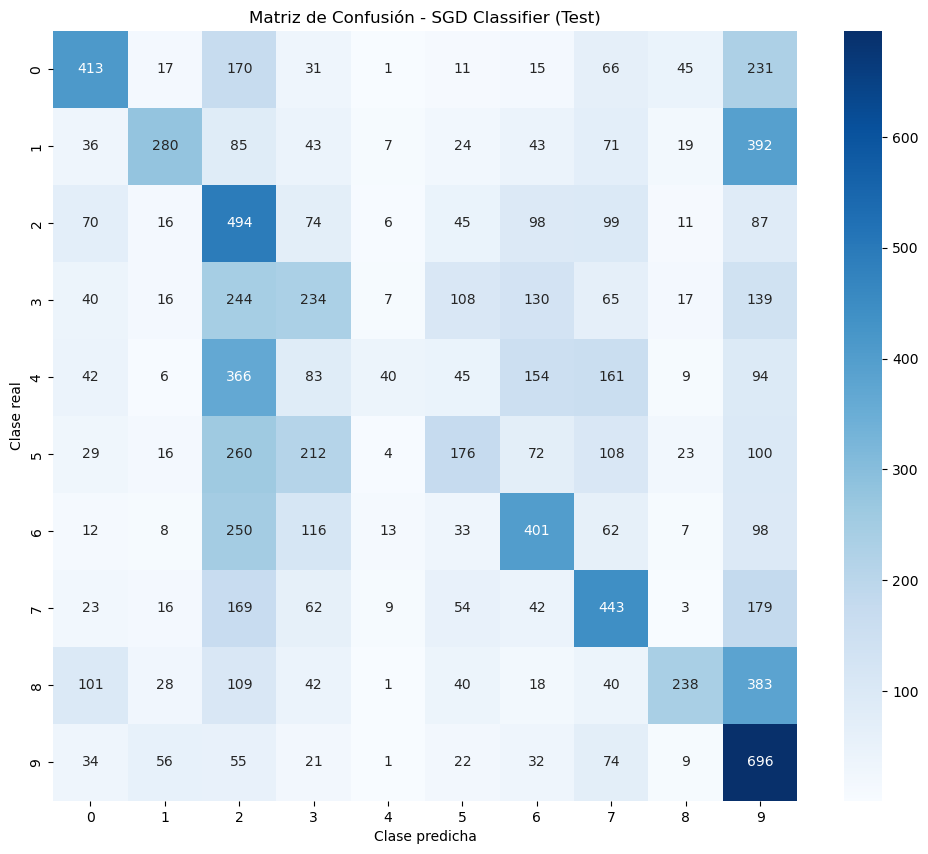

Reporte de clasificación para SGD Classifier en el conjunto de prueba:
              precision    recall  f1-score   support

    airplane       0.52      0.41      0.46      1000
  automobile       0.61      0.28      0.38      1000
        bird       0.22      0.49      0.31      1000
         cat       0.25      0.23      0.24      1000
        deer       0.45      0.04      0.07      1000
         dog       0.32      0.18      0.23      1000
        frog       0.40      0.40      0.40      1000
       horse       0.37      0.44      0.40      1000
        ship       0.62      0.24      0.34      1000
       truck       0.29      0.70      0.41      1000

    accuracy                           0.34     10000
   macro avg       0.41      0.34      0.33     10000
weighted avg       0.41      0.34      0.33     10000



In [67]:
# Usar el modelo multiclase para calcular métricas
y_train_pred_sgd = sgd_clf_multi.predict(X_train.reshape(X_train.shape[0], -1))
y_test_pred_sgd = sgd_clf_multi.predict(X_test.reshape(X_test.shape[0], -1))

cm_train_sgd = confusion_matrix(y_train, y_train_pred_sgd)
cm_test_sgd = confusion_matrix(y_test, y_test_pred_sgd)

cm_test_sgd_df = pd.DataFrame(cm_test_sgd, index=class_names, columns=class_names)

# Mostrar como heatmap
plt.figure(figsize=(12,10))
sns.heatmap(cm_test_sgd, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión - SGD Classifier (Test)")
plt.ylabel("Clase real")
plt.xlabel("Clase predicha")
plt.show()

print("Reporte de clasificación para SGD Classifier en el conjunto de prueba:")
print(classification_report(y_test, y_test_pred_sgd, target_names=class_names))